In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix,precision_recall_curve
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb 
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

warnings.filterwarnings('ignore')
raw_data = pd.read_csv('./BankChurners.csv')

In [230]:
raw_data.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [231]:
## 맨 뒤에 2열 제거, 맨 앞에 1열 제거 

raw_data = raw_data.iloc[:, :-2]
raw_data = raw_data.iloc[:, 1:]

In [232]:
raw_data.head(5)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## EDA (함수 이용)

### 1. Basic EDA 

In [233]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    ## 컬럼 개수가 list_elements_limit보다 많으면 list_elements_limit개 까지만 표시 
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

In [234]:
basic_eda(raw_data)

Info : There are 20 columns in the dataset
Info : There are 10127 rows in the dataset

Data type information of different columns
Info : There are 6 categorical columns
Info : There are 14 numerical columns
Categorical columns :  ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Numerical columns :  ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1']


,column_name,dtype
0,Attrition_Flag,object
1,Customer_Age,int64
2,Gender,object
3,Dependent_count,int64
4,Education_Level,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,Customer_Age,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
1,Dependent_count,10127.0,2.346203,1.298908,0.0,1.0,2.0,3.0,5.0
2,Months_on_book,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
3,Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.0,4.0,5.0,6.0
4,Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Attrition_Flag,10127,2,Existing Customer,8500
1,Gender,10127,2,F,5358
2,Education_Level,10127,7,Graduate,3128
3,Marital_Status,10127,4,Married,4687
4,Income_Category,10127,6,Less than $40K,3561


### 2. Missing Value Details 

In [235]:
def missing_values_details(df):
    total = df.isnull().sum()
    
    missing_df = pd.DataFrame({'count_missing': total}).reset_index().rename(columns={'index':'column_name'})
    missing_df['percent_missing'] = missing_df['count_missing']/len(df)
    missing_df = missing_df.sort_values(by='count_missing', ascending=False)
    missing_df = missing_df[missing_df['count_missing']!=0]
    print('Info : {} out of {} columns have mising values'.format(len(missing_df), len(df.columns)))
    missing_90 = missing_df[missing_df['percent_missing']>0.9]
    missing_80 = missing_df[missing_df['percent_missing']>0.8]
    missing_70 = missing_df[missing_df['percent_missing']>0.7]
    print("Info : {} columns have more that 90% missing values".format(len(missing_90)))
    print("Info : {} columns have more that 80% missing values".format(len(missing_80)))
    print("Info : {} columns have more that 70% missing values".format(len(missing_70)))
    
    return missing_df

In [236]:
missing_values_details(raw_data)

Info : 0 out of 20 columns have mising values
Info : 0 columns have more that 90% missing values
Info : 0 columns have more that 80% missing values
Info : 0 columns have more that 70% missing values


,column_name,count_missing,percent_missing


### 3. Target 변수 

In [237]:
def check_class_balance(df, target_col):
    counts = df[target_col].value_counts()
    class_df = pd.DataFrame(counts).reset_index().rename(columns={target_col:'counts', 'index':'class'})
    class_df.plot.bar(x='class', y='counts')
    print('Info : There are {} classes in the target column'.format(len(class_df)))
    max_class = class_df['counts'].max() 
    min_class = class_df['counts'].min()
    max_diff = max_class - min_class
    print("Info : Maximum difference between 2 classes is {} observations that is {} times w.r.t. minimum class".format(max_diff, (max_diff/min_class)))
    return class_df

Info : There are 2 classes in the target column
Info : Maximum difference between 2 classes is 6873 observations that is 4.224339274738783 times w.r.t. minimum class


,class,counts
0,Existing Customer,8500
1,Attrited Customer,1627


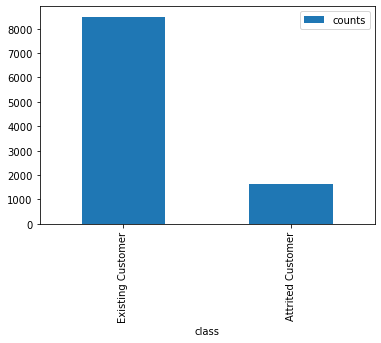

In [238]:
target_col = 'Attrition_Flag'
check_class_balance(raw_data, target_col)

### 4. Categorical 변수 탐색

In [239]:
# List of categorical columns in training set
cat_cols = list(raw_data.dtypes[raw_data.dtypes == 'object'].index)
cat_cols

['Attrition_Flag',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [240]:
def describe_cat_col(df, col):
    ### unique values
    count_u = df[col].nunique()
    print("Info : There are {} unique values".format(count_u))
    nulls = df[col].isnull().sum()
    print("Info : There are {} missing values that is {} percent".format(nulls, nulls/len(df)))
    
    ### Percent share df
    share_df = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={'index':'class_name',col:'counts'})
    share_df['percent_share'] = share_df['counts']/sum(share_df['counts'])
    share_df = share_df.sort_values(by='percent_share', ascending=False)
    #display(share_df)
        
        
    if (count_u > 3 and count_u < 10):
        fig, ax  = plt.subplots()
        fig.suptitle(col + ' Distribution', color = 'red')
        explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
        labels = list(df[col].dropna().unique())
        sizes = df[col].value_counts()
        #ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
        ax.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
        ax.add_artist(plt.Circle((0,0),0.2,fc='white'))
        plt.show()
    
    else:
        plt.figure()
        plt.title(col + ' Distribution', color = 'red')
        sns.countplot(y =col, data = df)
        plt.show()
        
    return

Info : There are 2 unique values
Info : There are 0 missing values that is 0.0 percent


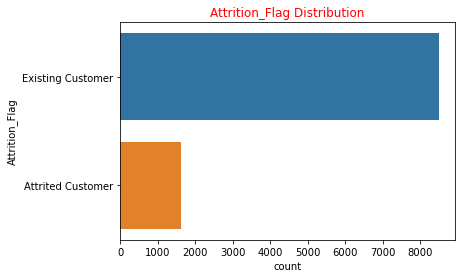

Info : There are 2 unique values
Info : There are 0 missing values that is 0.0 percent


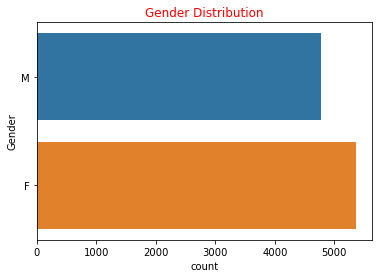

Info : There are 7 unique values
Info : There are 0 missing values that is 0.0 percent


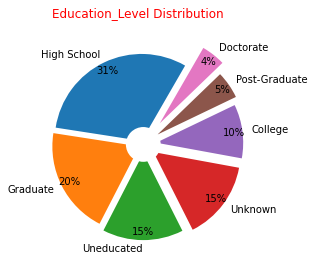

Info : There are 4 unique values
Info : There are 0 missing values that is 0.0 percent


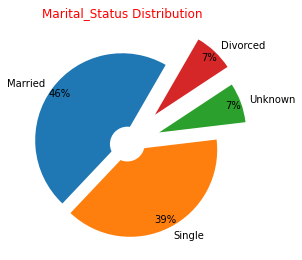

Info : There are 6 unique values
Info : There are 0 missing values that is 0.0 percent


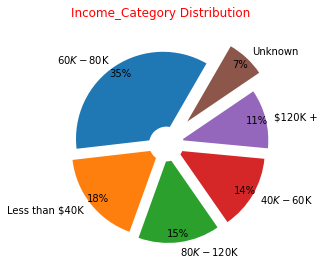

Info : There are 4 unique values
Info : There are 0 missing values that is 0.0 percent


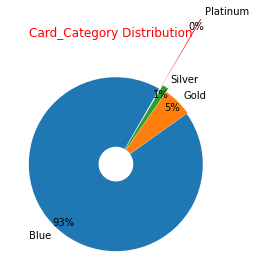

In [241]:
for col in cat_cols:
    #print("Column Name : {}".format(col))
    describe_cat_col(raw_data, col)    

### 5. Numeric 변수 탐색

In [242]:
num_cols = [col for col in raw_data.columns if col not in cat_cols]
#num_cols

In [243]:
def describe_num_col(train, col):
    #### This function provides detailed comparison of a numerical varible
    ### missing value
    count_train = train[col].isnull().sum()
    print("######    Variable Name : {}    ######".format(col))
    
    #### Skewness and Kurtosis
    train_k = stats.kurtosis(train[col].dropna(), bias=False)    
    train_s = stats.skew(train[col].dropna(), bias=False)
    
    #### Outliers
    
    def count_outliers(df, col):
        mean_d = np.mean(df[col])
        std_d = np.std(df[col])
        
        scaled = (df[col]-mean_d)/std_d
        outliers = abs(scaled) > 3
        if len(outliers.value_counts()) > 1:
            return outliers.value_counts()[1]
        else:
            return 0   
    
    train_o = count_outliers(train, col)
        
    summ_df = pd.DataFrame({'info':['missing_count', 'missing_percent', 'skewness', 'kurtosis', 'outlier_count', 'outlier_percent'],
                           'train_set':[count_train, (count_train/len(train))*100, train_s, train_k, train_o, (train_o/len(train))*100]})
    
    print("######    Summary Data")
    display(summ_df)
    
    #print("######    Distribution and Outliers comparision plots")
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    plot10 = sns.distplot(train[train['Attrition_Flag']=="Existing Customer"][col],ax=ax1, label='Existing Customer')
    sns.distplot(train[train['Attrition_Flag']=="Attrited Customer"][col],ax=ax1,color='red', label='Attrited Customer')
    plot10.axes.legend()
    ax1.set_title('Distribution of {name}'.format(name=col))
    
    sns.boxplot(x='Attrition_Flag',y=col,data=train,ax=ax2)
    #plt.xticks(ticks=[0,1],labels=['Non-Diabetes','Diabetes'])
    ax2.set_xlabel('Category') 
    ax2.set_title('Boxplot of {name}'.format(name=col))
    
    
    fig.show()    
    
    return 

######    Variable Name : Customer_Age    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,-0.033605
3,kurtosis,-0.288620
4,outlier_count,1.000000
5,outlier_percent,0.009875


######    Variable Name : Dependent_count    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,-0.020826
3,kurtosis,-0.683017
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Months_on_book    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,-0.106565
3,kurtosis,0.400100
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Total_Relationship_Count    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,-0.162452
3,kurtosis,-1.006131
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Months_Inactive_12_mon    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,0.633061
3,kurtosis,1.098523
4,outlier_count,124.000000
5,outlier_percent,1.224449


######    Variable Name : Contacts_Count_12_mon    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,0.011006
3,kurtosis,0.000863
4,outlier_count,54.000000
5,outlier_percent,0.533228


######    Variable Name : Credit_Limit    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,1.666726
3,kurtosis,1.808989
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Total_Revolving_Bal    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,-0.148837
3,kurtosis,-1.145992
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Avg_Open_To_Buy    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,1.661697
3,kurtosis,1.798617
4,outlier_count,0.000000
5,outlier_percent,0.000000


######    Variable Name : Total_Amt_Chng_Q4_Q1    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,1.732063
3,kurtosis,9.993501
4,outlier_count,163.000000
5,outlier_percent,1.609559


######    Variable Name : Total_Trans_Amt    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,2.041003
3,kurtosis,3.894023
4,outlier_count,391.000000
5,outlier_percent,3.860966


######    Variable Name : Total_Trans_Ct    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,0.153673
3,kurtosis,-0.367163
4,outlier_count,2.000000
5,outlier_percent,0.019749


######    Variable Name : Total_Ct_Chng_Q4_Q1    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,2.064031
3,kurtosis,15.689293
4,outlier_count,113.000000
5,outlier_percent,1.115829


######    Variable Name : Avg_Utilization_Ratio    ######
######    Summary Data


,info,train_set
0,missing_count,0.000000
1,missing_percent,0.000000
2,skewness,0.718008
3,kurtosis,-0.794972
4,outlier_count,0.000000
5,outlier_percent,0.000000


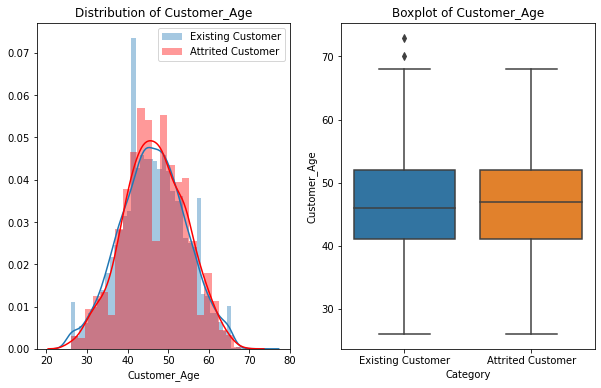

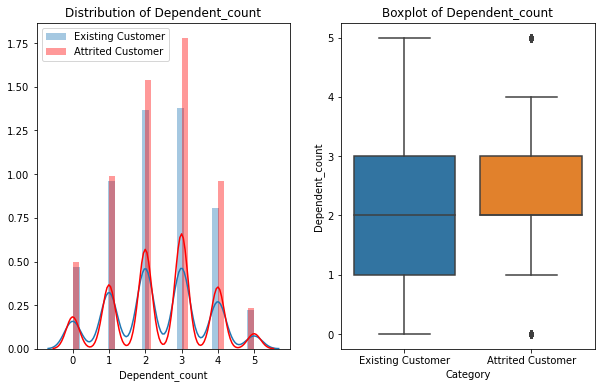

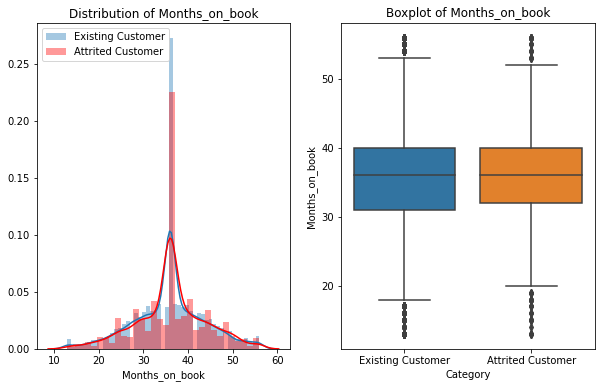

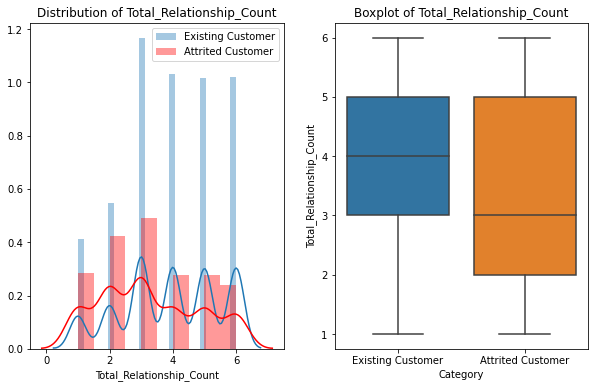

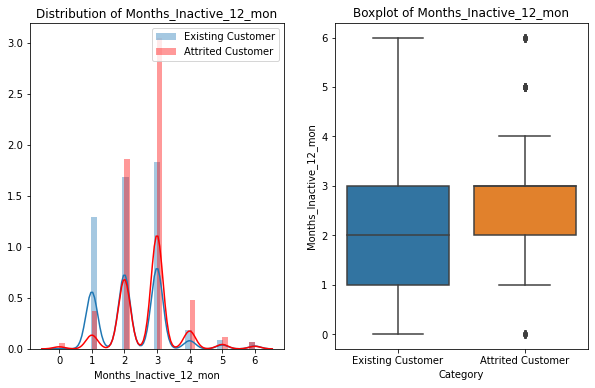

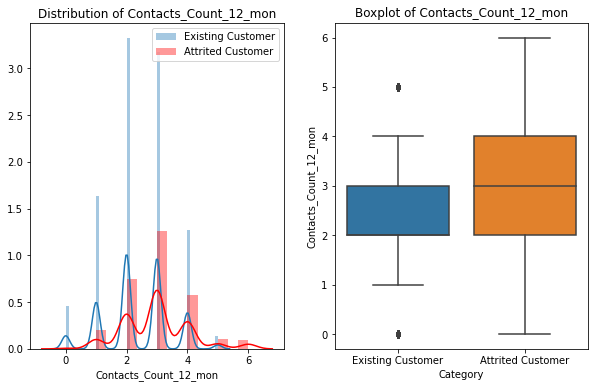

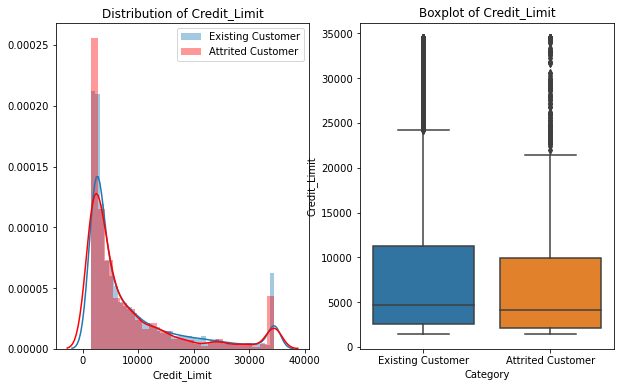

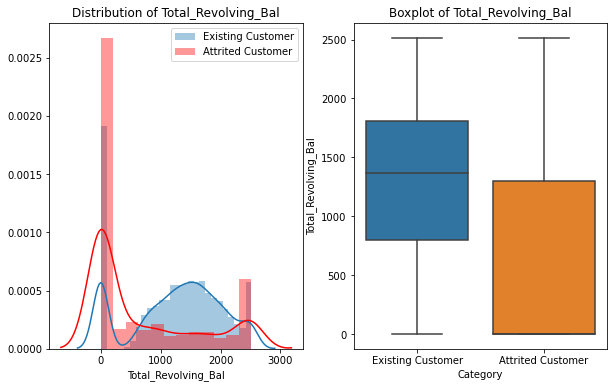

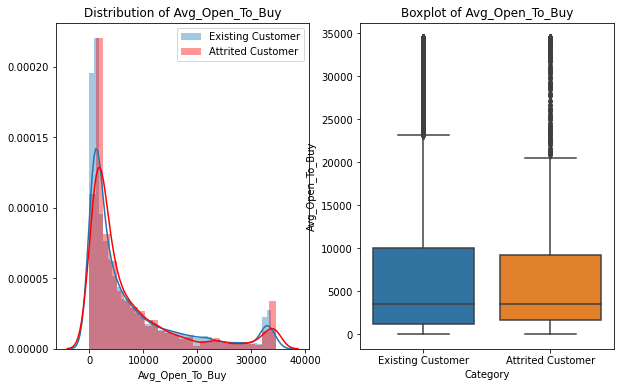

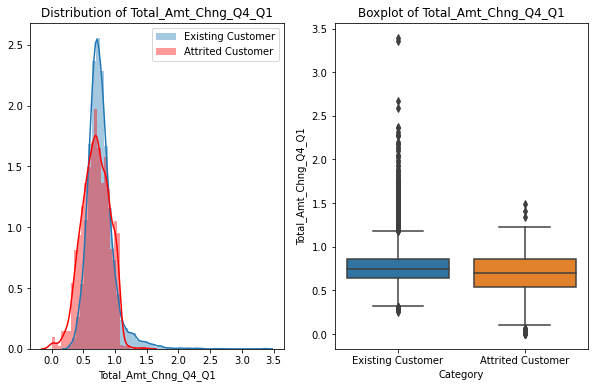

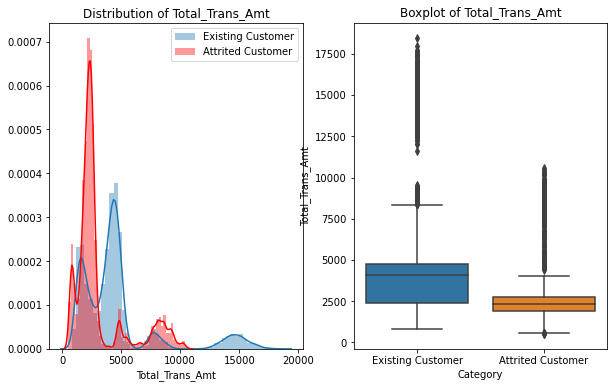

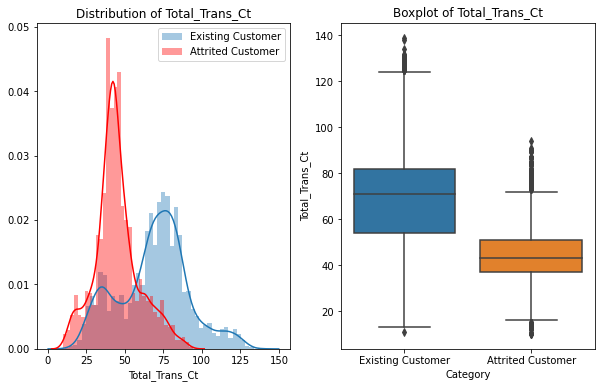

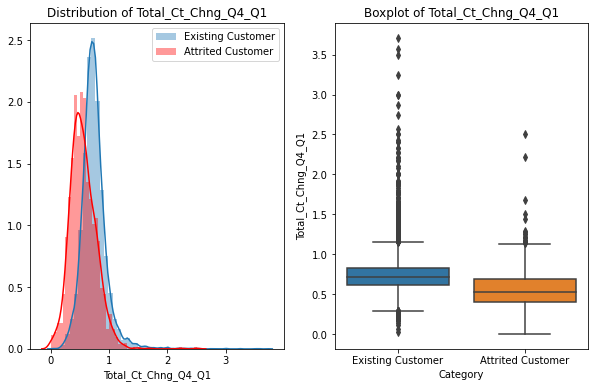

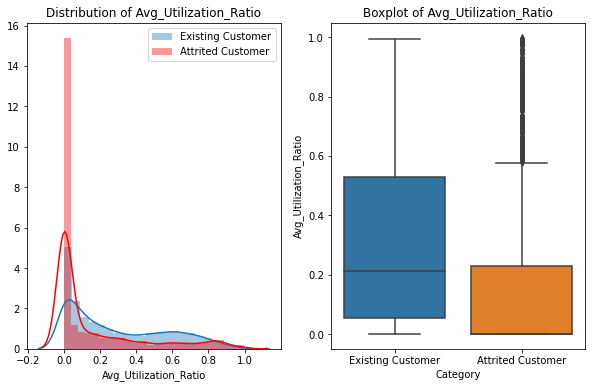

In [244]:
for col in num_cols:
    describe_num_col(raw_data, col)  

## Data Preprocessing

In [245]:
##  Education_Level, Income_Category의 'unknown'값은 np.nan으로 처리함 
## Marital_status은 one-hot으로 처리한 후 Unknown 열은 버림 

data = raw_data.copy()
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: 1 if x=='Attrited Customer' else 0)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x=='F' else 0)

edu_dict = {'Unknown':np.nan,'Uneducated':0,'High School':1,'College':2,
             'Graduate':3,'Post-Graduate':4,'Doctorate':5}
data['Education_Level'] = data['Education_Level'].apply(lambda x: edu_dict[x])

income_dict = {'Unknown':np.nan,'Less than $40K':0,'$40K - $60K':1,
                '$60K - $80K':2,'$80K - $120K':3,'$120K +':4}
data['Income_Category'] = data['Income_Category'].apply(lambda x: income_dict[x])

marital_onehot = pd.get_dummies(data['Marital_Status'],prefix='Marital_Status')
data = pd.concat([data,marital_onehot],axis=1)
data.drop(columns=['Marital_Status','Marital_Status_Unknown'],axis=1,inplace=True)

In [246]:
## 추가 인코딩을 위해 train, test 나눔 

X = data.drop(columns='Attrition_Flag',axis=1)
y = data['Attrition_Flag']
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=42)

In [247]:
## card_category에서는 blue가 압도적으로 많았으므로 countencoder를 해줌 

count_enc = ce.CountEncoder(cols='Card_Category')
count_encoded = count_enc.fit(train_x['Card_Category'])
train_x = train_x.join(count_encoded.transform(train_x['Card_Category']).add_suffix('_count'))
test_x = test_x.join(count_encoded.transform(test_x['Card_Category']).add_suffix('_count'))
train_x.drop(columns='Card_Category',axis=1,inplace=True)
test_x.drop(columns='Card_Category',axis=1,inplace=True)

In [248]:
count_encoded

CountEncoder(cols=['Card_Category'], combine_min_nan_groups=True)

In [249]:
test_x.head(5)

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_count
3781,48,1,3,0.0,0.0,39,4,3,4,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504,0,0,1,7557
2922,59,0,1,0.0,0.0,53,5,5,4,2192.0,1569,623.0,0.706,4010,79,0.717,0.716,0,0,1,7557
5070,37,1,2,3.0,0.0,36,4,3,3,1734.0,987,747.0,0.879,4727,67,0.914,0.569,1,0,0,7557
7246,47,0,3,5.0,1.0,36,4,2,3,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317,1,0,0,7557
623,42,0,3,NaN,3.0,33,3,3,2,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584,0,0,1,7557


In [250]:
## Education_level, Incom_category의 null은 KNNimputer로 채워줌

Imputer = KNNImputer(missing_values = np.nan, n_neighbors=1, weights='uniform').fit(train_x)
imputed_train_x = Imputer.transform(train_x)
imputed_test_x = Imputer.transform(test_x)

In [251]:
np.sum(np.isnan(imputed_train_x)),np.sum(np.isnan(imputed_test_x))

(0, 0)

### Check Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

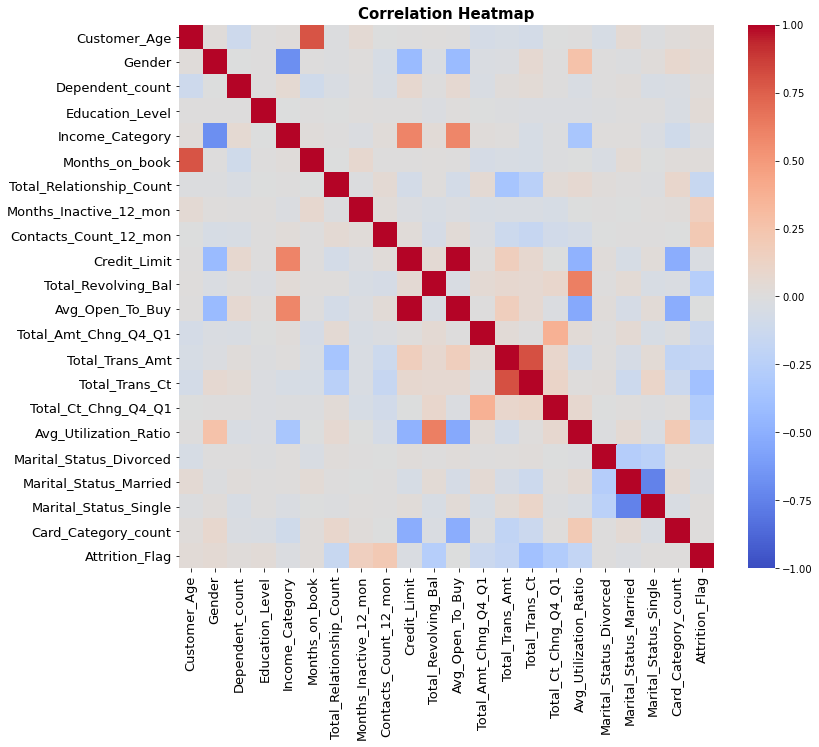

In [252]:
imputed_train = np.column_stack((imputed_train_x,train_y))
df_imputed_train = pd.DataFrame(imputed_train)
df_imputed_train.columns = list(train_x.columns) + ['Attrition_Flag']

corr = df_imputed_train.corr()
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr,ax=ax,vmin=-1, vmax=1, cmap='coolwarm', annot=False)
plt.yticks(rotation=0,fontsize=13)
plt.xticks(rotation=90,fontsize=13)
ax.set_title('Correlation Heatmap',fontsize=15,fontweight='bold')

# highly positively correlation between 'Avg_Open_To_Buy' and 'Credit_Limit'.
# highly negatively correlation betweern 'Marital_Status_Single' and 'Marital_Status_Married'.

In [253]:
## 상관계수가 0.9 이상이면 해당 컬럼 삭제 (j가 삭제되는듯..?)

columns = np.full(shape=(corr.shape[0],), fill_value=True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
sel_columns = df_imputed_train.columns[columns]
df_imputed_train = df_imputed_train[sel_columns]
df_imputed_train.columns

## -> Avg_Open_To_Buy 삭제됨 

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Income_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Card_Category_count', 'Attrition_Flag'],
      dtype='object')

In [254]:
cleaned_train_x = df_imputed_train.drop(columns='Attrition_Flag',axis=1)
df_imputed_test_x = pd.DataFrame(imputed_test_x)
df_imputed_test_x.columns = test_x.columns
cleaned_test_x = df_imputed_test_x.drop(columns='Avg_Open_To_Buy',axis=1)

## Modeling

### SMOTE + RUS
(minor 클래스에 대해 over sampling + major 클래스에 대해 under sampling)

In [255]:
y_cnt_before = train_y.value_counts()
trace = go.Pie(labels = y_cnt_before.index, 
               values = y_cnt_before.values,
               hoverinfo = 'percent+value+label',
               textinfo = 'percent',
               textposition = 'inside',
               textfont = dict(size=14),
               title = 'Attrition Flag',
               titlefont = dict(size=15),
               hole = 0.5,
               showlegend = True,
               marker = dict(line=dict(color='black',width=2)))
fig = go.Figure(data=[trace])
fig.update_layout(height=500, width=500)
fig.show()

In [256]:
over_sampling = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=42)
under_sampling = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
pipeline = Pipeline(steps=[('o',over_sampling),('u',under_sampling)])
ou_train_x,ou_train_y = pipeline.fit_resample(cleaned_train_x,train_y)

In [257]:
y_cnt_after = ou_train_y.value_counts()
trace = go.Pie(labels = y_cnt_after.index, 
               values = y_cnt_after.values,
               hoverinfo = 'percent+value+label',
               textinfo = 'percent',
               textposition = 'inside',
               textfont = dict(size=14),
               title = 'Attrition Flag',
               titlefont = dict(size=15),
               hole = 0.5,
               showlegend = True,
               marker = dict(line=dict(color='black',width=2)))
fig = go.Figure(data=[trace])
fig.update_layout(height=500, width=500)
fig.show()

### Reverse Recall Function, Evaluate Function

In [263]:
def rev_recall(pred,dtrain):
    labels = dtrain.get_label()
    pred = np.round(1.0 / (1.0 + np.exp(-pred)))
    cm = confusion_matrix(labels, pred)
    recall =float(cm[1][1]) / float(cm[1][0]+cm[1][1])
    reversed_recall = 1-recall
    return 'Reversed-Recall',reversed_recall

In [279]:
from sklearn.metrics import confusion_matrix, auc
from sklearn import metrics

def evaluate_model_performnce(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizing model performance
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

    tn, fp, fn, tp = cm.ravel()
    #print(tn, fp, fn, tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = ((tp+tn)/(tp+tn+fp+fn))*100
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    
    return accuracy, auc, f1

### Modeling1. Base Model (XGBoost)

In [286]:
baseline_params = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'random_state': 42}

baseline_xgb = xgb.XGBClassifier(**baseline_params)
baseline_xgb.fit(ou_train_x,ou_train_y, eval_metric=rev_recall,
                 eval_set=[(ou_train_x,ou_train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[14:20:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.48861	validation_0-Reversed-Recall:0.12647	validation_1-logloss:0.49348	validation_1-Reversed-Recall:0.17431
[1]	validation_0-logloss:0.37073	validation_0-Reversed-Recall:0.07610	validation_1-logloss:0.37854	validation_1-Reversed-Recall:0.12844
[2]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)

Precision :  0.8691860465116279
Recall :  0.9143730886850153
F1 Score :  0.8912071535022356
Validation Accuracy :  96.39684106614018
Accuracy Score :  0.9639684106614018
AUC Value :  0.9439434601753506


(0.9639684106614018, 0.9439434601753506, 0.8912071535022356)

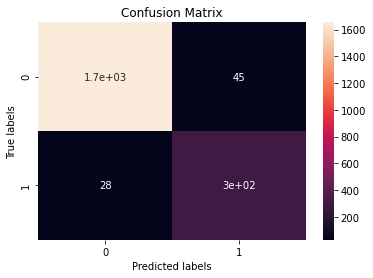

In [280]:
pred_y = baseline_xgb.predict(cleaned_test_x)

evaluate_model_performnce(test_y,pred_y)

Text(0.5, 1.0, 'Feature Importance')

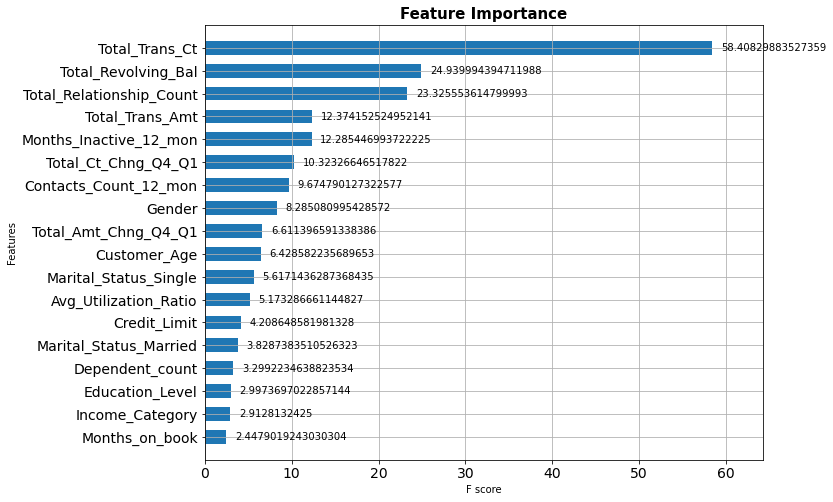

In [216]:
fig,ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(baseline_xgb,ax=ax,importance_type='gain',height=0.6, max_num_features=None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Feature Importance',fontsize=15,fontweight='bold')

### Modeling2. Change Class Weight 

In [283]:
baseline_params_2 = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'scale_pos_weight':3,
                   'random_state': 42}

xgb_2 = xgb.XGBClassifier(**baseline_params_2)
xgb_2.fit(cleaned_train_x,train_y, eval_metric=rev_recall,
                 eval_set=[(cleaned_train_x,train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[14:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.48295	validation_0-Reversed-Recall:0.09000	validation_1-logloss:0.49185	validation_1-Reversed-Recall:0.13150
[1]	validation_0-logloss:0.35968	validation_0-Reversed-Recall:0.07615	validation_1-logloss:0.37429	validation_1-Reversed-Recall:0.13150
[2]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)

Precision :  0.8494318181818182
Recall :  0.9143730886850153
F1 Score :  0.8807069219440353
Validation Accuracy :  96.00197433366239
Accuracy Score :  0.9600197433366239
AUC Value :  0.9415891341011892


(0.9600197433366239, 0.9415891341011892, 0.8807069219440353)

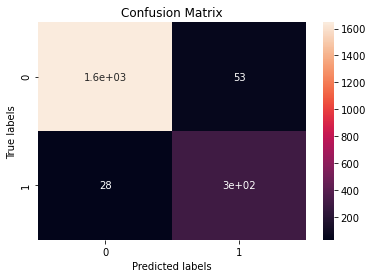

In [282]:
pred_y_2 = xgb_2.predict(cleaned_test_x)

evaluate_model_performnce(test_y,pred_y_2)

Text(0.5, 1.0, 'Feature Importance')

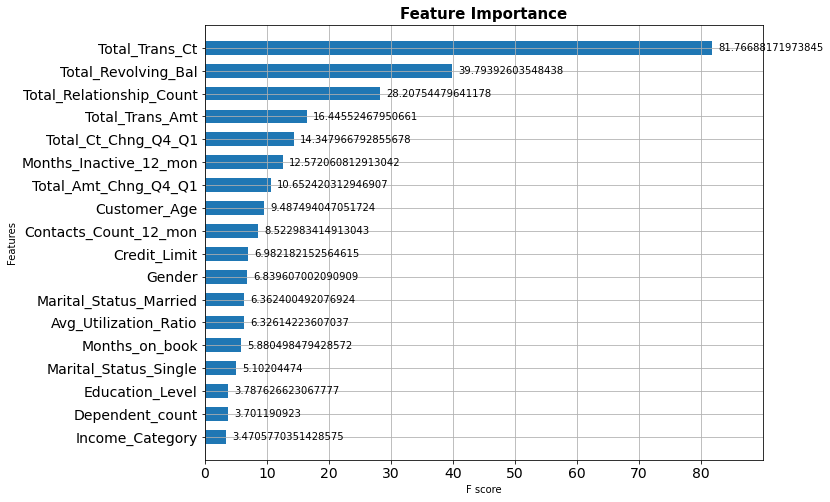

In [219]:
fig,ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xgb_2,ax=ax,importance_type='gain',height=0.6, max_num_features=None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Feature Importance',fontsize=15,fontweight='bold')

### Modeling3. Threshold Moving

In [285]:
baseline_params_3 = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'random_state': 42}

xgb_3 = xgb.XGBClassifier(**baseline_params_3)
xgb_3.fit(cleaned_train_x,train_y, eval_metric=rev_recall,
                 eval_set=[(cleaned_train_x,train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[14:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.48163	validation_0-Reversed-Recall:0.19846	validation_1-logloss:0.48845	validation_1-Reversed-Recall:0.24771
[1]	validation_0-logloss:0.35923	validation_0-Reversed-Recall:0.19077	validation_1-logloss:0.37068	validation_1-Reversed-Recall:0.24465
[2]	validation_0-loglos

[55]	validation_0-logloss:0.02718	validation_0-Reversed-Recall:0.02385	validation_1-logloss:0.08536	validation_1-Reversed-Recall:0.11621
[56]	validation_0-logloss:0.02672	validation_0-Reversed-Recall:0.02231	validation_1-logloss:0.08540	validation_1-Reversed-Recall:0.11927
[57]	validation_0-logloss:0.02644	validation_0-Reversed-Recall:0.02308	validation_1-logloss:0.08580	validation_1-Reversed-Recall:0.12232
[58]	validation_0-logloss:0.02623	validation_0-Reversed-Recall:0.02000	validation_1-logloss:0.08629	validation_1-Reversed-Recall:0.12232
[59]	validation_0-logloss:0.02584	validation_0-Reversed-Recall:0.02077	validation_1-logloss:0.08587	validation_1-Reversed-Recall:0.12232
[60]	validation_0-logloss:0.02549	validation_0-Reversed-Recall:0.02077	validation_1-logloss:0.08637	validation_1-Reversed-Recall:0.11927
[61]	validation_0-logloss:0.02520	validation_0-Reversed-Recall:0.02000	validation_1-logloss:0.08646	validation_1-Reversed-Recall:0.12538
[62]	validation_0-logloss:0.02488	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)


Precision Recall curve and F-score are chosen to find the best threshold because they reveal the model performance well when the dataset is imbalanced.

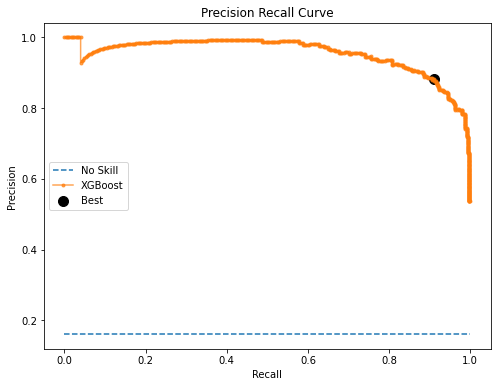

In [222]:
pred_y_3 = xgb_3.predict_proba(cleaned_test_x)
class_1_proba = pred_y_3[:,1]
precision, recall, thresholds = precision_recall_curve(test_y, class_1_proba)
f_score = (2*precision*recall)/(precision+recall)
idx = np.argmax(f_score)

no_skill = np.sum(test_y) / len(test_y)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
ax.plot(recall, precision, marker='.', label='XGBoost',alpha=0.7)
ax.scatter(recall[idx], precision[idx], s=100, marker='o', color='black', label='Best')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.legend(loc='center left')

In [223]:
print('best threshold is %f' % (thresholds[idx]))

best threshold is 0.361663


Precision :  0.8816568047337278
Recall :  0.9113149847094801
F1 Score :  0.8962406015037594
Validation Accuracy :  96.59427443237907
Accuracy Score :  0.9659427443237907
AUC Value :  0.9438858619839338


(0.9659427443237907, 0.9438858619839338, 0.8962406015037594)

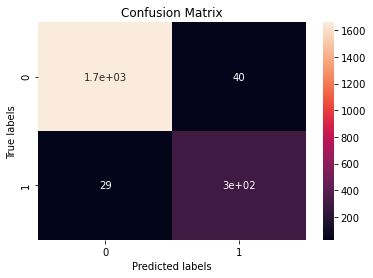

In [287]:
best_threshold = thresholds[idx]
final_pred_y_3 = [1 if p>=best_threshold else 0 for p in class_1_proba]

evaluate_model_performnce(test_y,final_pred_y_3)

In [261]:
all_recalls = [float(confusion_matrix(test_y,y_hat)[1][1]/np.sum(confusion_matrix(test_y,y_hat),axis=1)[1]) 
               for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_precisions = [float(confusion_matrix(test_y,y_hat)[1][1]/np.sum(confusion_matrix(test_y,y_hat),axis=0)[1]) 
                  for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_acc = [float((confusion_matrix(test_y,y_hat)[1][1]+confusion_matrix(test_y,y_hat)[0][0])/len(test_y)) 
           for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_methods = ['SMOTE','Change Class Weight','Move Threshold']

fig = go.Figure(data=[go.Table(header=dict(values=['Method','Recall', 'Precision','Accuracy'], 
                               fill_color='yellow', line_color='black'),
                               cells=dict(values=[all_methods,all_recalls,all_precisions,all_acc], 
                               fill_color='lavender', line_color='black'))])
fig.update_layout(width=800,height=700)
fig.show()